### Дипломный проект на тему «Модель прогнозирования стоимости жилья для агентства недвижимости».

Проблема:  
агентство недвижимости столкнулось с проблемой — риелторы тратят слишком много времени на сортировку объявлений и поиск выгодных предложений. Поэтому скорость их реакции и качество анализа не дотягивают до уровня конкурентов. Это сказывается на финансовых показателях агентства.

Цели проекта:  
разработать модель, которая позволила бы агентству недвижимости обойти конкурентов по скорости и качеству совершения сделок.

Основные цели проекта:  
- Провести разведывательный анализ и очистку исходных данных. В данных присутствуют дублирующиеся категории, ошибки ввода, жаргонные сокращения и т.д. Предстоит отыскать закономерности, расшифровать все сокращения, найти синонимы в данных, обработать пропуски и удалить выбросы.  
- Выделить наиболее значимые факторы, влияющие на стоимость недвижимости.  
- Построить несколько моделей для прогнозирования стоимости недвижимости, оценить их метрики качества и выбрать оптимальный вариант.  

In [1]:
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import pickle
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import linear_model
from sklearn import preprocessing
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import tree 
from sklearn import metrics
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

Описание данных:  
**status** — статус продажи;  
**private pool** и **PrivatePool** — наличие собственного бассейна;  
**propertyType** — тип объекта недвижимости;  
**street** — адрес объекта;  
**baths** — количество ванных комнат;  
**homeFacts** — сведения о строительстве объекта (содержит несколько типов сведений, влияющих на оценку объекта);  
**fireplace** — наличие камина;  
**city** — город;  
**schools** — сведения о школах в районе;  
**sqft** — площадь в футах;  
**zipcode** — почтовый индекс;  
**beds** — количество спален;  
**state** — штат;  
**stories** — количество этажей;  
**mls-id** и **MlsId** — идентификатор MLS (Multiple Listing Service, система мультилистинга);  
**target** — цена объекта недвижимости **(целевой признак, который необходимо спрогнозировать)**.

In [2]:
# Импорт и вывод данных.
df = pd.read_csv('data.csv')
df.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


In [3]:
# Выводим общую информацию по датасету.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

# Обработка и очистка данных

In [4]:
# Проверим наличие дубликатов.
data_shape = df.duplicated().sum()
df = df.drop_duplicates()
print('Количество найденных дубликатов:', data_shape)
print('Количество оставшихся строк в таблице:', df.shape[0])

Количество найденных дубликатов: 50
Количество оставшихся строк в таблице: 377135


### Признаки **'private pool'** и **'PrivatePool'** с наличием собственного бассейна

In [5]:
# Посмотрим на признаки 'private pool' и 'PrivatePool', которые имеют больше всего пропусков.
# Данные признаки идентичные и означают наличие бассейна.
print(df['private pool'].unique())
print(df['PrivatePool'].unique())

[nan 'Yes']
[nan 'yes' 'Yes']


В рассмотренных признаках есть только значения 'yes', но нет значения 'no'. Отсюда можно сделать вывод, что пропуски означают отсутствие бассейна.
Объеденим данные признаки в один, который указывает на наличие бассейна.

In [6]:
# Обновляем значения NaN значениями в той же позиции из другого дублирующего признака.
# и заполняем пропуски значением 'No' в новом признаке, после чего удалим исходные признаки.
df['pool'] = df['PrivatePool'].combine_first(df['private pool'])
df['pool'] = df['pool'].apply(lambda x: 'no' if (x is np.NaN) else 'yes')
df = df.drop(['PrivatePool', 'private pool'], axis=1)

### Признак **status** — статус продажи

In [7]:
# В признаке 'status', сгруппируем значения в категории при помощи регулярных выражений.
df['status'] = df['status'].str.lower()
df['status'] = df['status'].replace(r'.*activ.*', 'Active', regex=True)
df['status'] = df['status'].replace(r'.*auction.*', 'Auction', regex=True)
df['status'] = df['status'].replace(r'.*back.*', 'Back on market', regex=True)
df['status'] = df['status'].replace(r'.*conting.*', 'Contingent', regex=True)
df['status'] = df['status'].replace(r'.*under contract.*', 'Under contract', regex=True)
df['status'] = df['status'].replace(r'contract.*|.*option contract.*|.*Ct.*', 'Contract', regex=True)
df['status'] = df['status'].replace(r'.*for.*sale.*|.*new.*', 'For sale', regex=True)
df['status'] = df['status'].replace(r'.*for.*rent.*|.*rent.*', 'For rent', regex=True)
df['status'] = df['status'].replace(r'.*foreclos.*', 'Foreclosure', regex=True)
df['status'] = df['status'].replace(r'.*pending.*', 'Pending', regex=True)
df['status'] = df['status'].replace(r'.*price.*change.*|.*change.*', 'Price change', regex=True)
df['status'] = df['status'].replace(r'.*recently.*', 'Recently sold', regex=True)

# Замена оставшихся значений на 'Other'.
status_list = ['Active', 'Auction', 'Back on market', 'Contingent', 'Under contract', 'Contract', \
'For sale', 'For rent', 'Foreclosure', 'Pending', 'Price change', 'Recently sold']
df['status'] = df['status'].apply(lambda x: x if x in status_list else 'Other')

# Посмотрим на получившиеся категории в признаке 'status'.
df_status = df['status'].value_counts().sort_index(key=lambda x: x.str.lower()).to_frame()
df_status = df_status.rename(columns={'status':'counts'})
df_status = df_status.reset_index().rename(columns={'index':'status'})
display(df_status)

,status,counts
0,Active,106558
1,Auction,3032
2,Back on market,475
3,Contingent,1057
4,Contract,91
5,For rent,412
6,For sale,205688
7,Foreclosure,9346
8,Other,44392
9,Pending,5234


### Признак **'street'** с адресом объекта

In [8]:
# Признак 'propertyType' имеет очень много значений и они не поддаются группировке. Поэтому удалим этот признак.
df = df.drop(['propertyType'], axis=1)

# Выведем значения с адресами объектов, а так же их количество в процентах.
display(df['street'].value_counts())
print('Количество уникальных адресов составляет', round((df['street'].value_counts().shape[0]/df.shape[0])*100), 'процентов.')

Address Not Disclosed        672
Undisclosed Address          517
(undisclosed Address)        391
Address Not Available        175
Unknown Address               72
                            ... 
1737 Parkview Green Cir        1
14890 Rockridge Ln             1
497 Kingswood Dr               1
202 Seacrest Beach Blvd W      1
5983 Midcrown Dr               1
Name: street, Length: 337076, dtype: int64

Количество уникальных адресов составляет 89 процентов.


Так как количество уникальных адресов составляет 89 процентов и они не структурированы, а также по количеству преобладают неуказанные адреса, то от них можно избавиться.

In [9]:
# Удаляем признак с адресом.
df = df.drop(['street'], axis=1)

### Признак **'baths'** с количеством ванных комнат.

In [10]:
# Посмотрим на признак 'baths' с количеством ванных комнат. 
df_baths = df['baths'].value_counts().sort_values(ascending=False)
display(df_baths.head(20))

2 Baths         52458
3 Baths         35503
2               20452
2.0             16575
4 Baths         14763
3.0             10868
3               10113
Bathrooms: 2     9538
2.5              8113
Bathrooms: 3     6613
1                6583
1.0              5930
5 Baths          5370
4.0              4593
2.5 Baths        4486
0                3811
4                3567
3.5              3455
Bathrooms: 1     3234
2 ba             2686
Name: baths, dtype: int64

Видно, что данный признак имеет как целые числа, так и дробные. Скорее всего это означает не количество ванных комнат, как указано в данных, а их площадь. Поэтому преобразуем признак в тип float.

In [11]:
# Обработаем признак 'baths' с количеством ванных комнат и преобразуем в тип 'float'. 
df['baths'] = df['baths'].str.lower()\
.replace(r',', '.', regex=True)\
.replace(r'[^0-9.].*$', '', regex=True)
df['baths'].fillna(0, inplace=True)
df['baths'] = df['baths'].replace(r'', 'o', regex=True)
df['baths'] = df['baths'].replace(r'o', '0', regex=True)
df['baths'] = df['baths'].astype(float)
df['baths'].fillna(df['baths'].mode(), inplace=True)
df['baths'] = df['baths'].apply(lambda x: np.round(x,2))

# Выводим обработанный признак с количеством отдельных значений.
df_baths = df['baths'].value_counts().sort_values(ascending=False)
display(df_baths.head(20))

0.00     135003
2.00      93972
3.00      60066
4.00      23948
1.00      14553
2.50      13786
5.00       8630
3.50       6151
1.50       4363
6.00       3950
7.00       1931
1.75       1817
4.50       1560
2.25       1459
1.25       1216
8.00       1069
2.75       1000
5.50        522
9.00        511
10.00       302
Name: baths, dtype: int64

### Признак **'homeFacts'** со сведениями о строительстве объекта (содержит несколько типов сведений, влияющих на оценку объекта)

In [12]:
# Посмотрим на признак 'homeFacts'.
df_homeFacts = df['homeFacts'].value_counts().sort_index(key=lambda x: x.str.lower()).to_frame()
display(df_homeFacts.head())
print('Количество уникальных значений: ', df['homeFacts'].nunique())

,homeFacts
"{'atAGlanceFacts': [{'factValue': '', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': ' Apply', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': '479160', 'factLabel': 'lotsize'}, {'factValue': None, 'factLabel': 'Price/sqft'}]}",1
"{'atAGlanceFacts': [{'factValue': '', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': ' Apply', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': '653400', 'factLabel': 'lotsize'}, {'factValue': None, 'factLabel': 'Price/sqft'}]}",1
"{'atAGlanceFacts': [{'factValue': '', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': ' Apply', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': '718740', 'factLabel': 'lotsize'}, {'factValue': None, 'factLabel': 'Price/sqft'}]}",1
"{'atAGlanceFacts': [{'factValue': '', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': ' Apply', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': '784080', 'factLabel': 'lotsize'}, {'factValue': None, 'factLabel': 'Price/sqft'}]}",1
"{'atAGlanceFacts': [{'factValue': '', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': ""Traveling West on I-40:Take exit 146 (Stamey Farm Rd). Turn right onto Stamey Farm Rd. Watermelon Road is the first left off of Stamey Farm Rd. Property is the lot to the left directly beside Penske's facility. Parking available on Lonely Drive."", 'factLabel': 'Parking'}, {'factValue': '1372140', 'factLabel': 'lotsize'}, {'factValue': None, 'factLabel': 'Price/sqft'}]}",1


Количество уникальных значений:  321009


Как можно видеть, в признаке присутствуют категории 'Label' и их значения 'Value'. Преобразуем с помощью регулярных выражений признак 'homeFacts'.

In [13]:
# Преобразуем с помощью регулярных выражений признак 'homeFacts'.
label = df['homeFacts'].str.findall(r"\bfactLabel': ([\s\S]+?)[}\b]")
Value = df['homeFacts'].str.findall(r"\bfactValue': ([\s\S]+?), 'factLabel\b")

# Создадим список получившихся значений.
list_label = ','.join(label[0]).replace("'","").split(',')
list_label

['Year built',
 'Remodeled year',
 'Heating',
 'Cooling',
 'Parking',
 'lotsize',
 'Price/sqft']

In [14]:
# Создадим получившиеся признаки и заполним значениями.
for i, val in enumerate(list_label):
    df[val] = Value.apply(lambda x: x[i])

# Удаляем признак homeFacts после извлечения из него информации.
df = df.drop('homeFacts', axis=1)

### Признак **'Year built'**, полученный из признака 'homeFacts'

In [15]:
# Подсчитаем количество указанных годов постройки.
df_year = df['Year built'].value_counts().sort_index().to_frame()
df_year = df_year.rename(columns={'Year built':'counts'})
df_year = df_year.reset_index().rename(columns={'index':'year'})

# Посмотрим на получившиеся значения.
display(df_year.head(10))
display(df_year.tail(10))

,year,counts
0,'',58729
1,'1',2
2,'1019',1
3,'1057',1
4,'1060',1
5,'1208',1
6,'1700',1
7,'1703',2
8,'1735',1
9,'1740',1


,year,counts
221,'2017',5179
222,'2018',6855
223,'2019',32168
224,'2020',2435
225,'2021',62
226,'2022',8
227,'2025',2
228,'559990649990',2
229,'No Data',1222
230,None,3613


По данным видно, что есть выбросы 1, 1019, 1057, 1060, 1208 и 559990649990. Заменим эти значения, а также No Data и None на -1.  

В итоге получим признак с годом постройки. Но сам по себе год постройки не очень информативен. Будет гораздо удобнее и интуитивно понятнее, если перевести год постройки в возраст здания.

In [16]:
# Посчитаем количество пропусков, заменив маркером -1 выбросы и пробелы.
df['Year built'] = df['Year built'].str.replace(r'"','', regex=True).replace(r"'","", regex=True)
df['Year built'] = df['Year built'].replace(r'No Data', '0', regex=True)
df['Year built'] = df['Year built'].replace(r'None', '0', regex=True)
df['Year built'] = df['Year built'].replace(r'', '0', regex=True)
df['Year built'] = df['Year built'].apply(lambda x: x if (int(x)>=1700) & (int(x)<=2022) else -1)
df['Year built'] = df['Year built'].astype(int)

# Создаем признак 'age_building' с возрастом зданий.
df['age_building'] = df['Year built'].apply(lambda x: 2023 - x if x > 0 else x)
df = df.drop(['Year built'], axis=1)

print('Процент неуказанных возрастов у зданий: ', round(df[df['age_building']==(-1)].shape[0]/df.shape[0]*100), '%')

Процент неуказанных возрастов у зданий:  17 %


Количество объектов с неуказанным годом постройки составляет 17 процентов. Так как этот показатель является важным, то нужно его оставить, а пропуски удалить.

In [17]:
df = df[df['age_building'] > 0]

### Признак **'Remodeled year'**, полученный из признака 'homeFacts'

In [18]:
# Посмотрим на полученный признак 'Remodeled year'.
df_remodeled_year = df['Remodeled year'].value_counts().sort_values(ascending=False)
display(df_remodeled_year.head())

''        142164
None       21755
'2006'      5524
'2005'      4786
'2007'      4357
Name: Remodeled year, dtype: int64

In [19]:
# Преобразуем кавычки в None.
df['Remodeled year'] = df['Remodeled year'].replace(r"''", 'None', regex=True)

# Вычислим процент пропусков в признаке.
print('Процент пропущенных значений: ', round((df[df['Remodeled year'] == 'None'].shape[0]/df.shape[0])*100),'%')

Процент пропущенных значений:  52 %


Признак 'Remodeled year' имеет очень много пропусков - 52 процента. Поэтому его можно удалить.

In [20]:
df = df.drop(['Remodeled year'], axis=1)

### Признак отопления **'Heating'**, полученный из признака 'homeFacts'

In [21]:
# Посмотрим на признак 'Heating' и выведем 20 самых популярных значений.
df['Heating'] = df['Heating'].str.lower()
df_heating = df['Heating'].value_counts().sort_values(ascending=False)
display(df_heating.head(20))

'forced air'                     132742
''                                53632
'other'                           29403
'heat pump'                        8569
'no data'                          7855
'central air'                      7801
'electric'                         7471
'gas'                              7294
'central electric'                 7064
'central'                          6246
'central, electric'                4252
'baseboard'                        3796
'wall'                             3296
'electric heat'                    3056
'heating system'                   2709
'forced air, heat pump'            1718
'radiant'                          1484
'central air, ceiling fan(s)'      1432
'natural gas heat'                 1377
'central furnace'                  1009
Name: Heating, dtype: int64

Видно, что имеются пустые строки в количестве 53632. Также есть значения 'Other', 'No Data' и None, которые не несут никакой информации. Посчитаем эти значения в процентах.

In [22]:
# Маски для указанных значений.
mask_heat_1 = df['Heating'] == "''"
mask_heat_2 = df['Heating'] == "'no data'"
mask_heat_3 = df['Heating'] == "'other'"
mask_heat_4 = df['Heating'] == "none"
mask_heat_5 = df['Heating'] == "None"
mask_heat_6 = df['Heating'] == "' '"

df_heating = df[mask_heat_1 | mask_heat_2 | mask_heat_3 | mask_heat_4 | mask_heat_5 | mask_heat_6]
print('Процент пропущенных значений: ', round((df_heating.shape[0]/df.shape[0])*100), '%')

Процент пропущенных значений:  29 %


Пропусков 29 процентов. Заменим их на отсутствие отопления.

In [23]:
heating_list = ["''", "' '", "None", "'no data'", "'other'", "none"]
df['Heating'] = df['Heating'].apply(lambda x: 'no' if x in heating_list else 'yes')

### Признак **'Cooling'**, полученный из признака 'homeFacts', указывающий на наличие кондиционера 

In [24]:
# Посмотрим на популярные значения признака 'Cooling'.
df['Cooling'] = df['Cooling'].str.lower()
df_Cooling = df['Cooling'].value_counts().sort_values(ascending=False)
display(df_Cooling.head(20))

'central'                                            156365
''                                                    63909
'central air'                                         14363
'no data'                                              9835
'has cooling'                                          9717
'none'                                                 7359
'central electric'                                     6110
'wall'                                                 4006
'central gas'                                          3539
'central heating'                                      2802
'cooling system'                                       2700
'central a/c'                                          2036
'other'                                                1809
'central a/c (electric), central heat (gas)'           1646
'central a/c (electric), central heat (electric)'      1429
'refrigeration'                                        1075
'central, electric'                     

In [25]:
# Подсчитаем сумму значений '', 'No Data', 'None' и 'Other' в процентах.
mask_cooling1 = df['Cooling'] == "''"
mask_cooling2 = df['Cooling'] == "'no data'"
mask_cooling3 = df['Cooling'] == "'none'"
mask_cooling4 = df['Cooling'] == "'other'"
mask_cooling5 = df['Cooling'] == "None"
mask_cooling6 = df['Cooling'] == "' '"
df_cooling = df[mask_cooling1 | mask_cooling2 | mask_cooling3 | mask_cooling4 | mask_cooling5 | mask_cooling6]

print('Процент пропущенных значений: ', round((df_cooling.shape[0]/df.shape[0])*100), '%')

Процент пропущенных значений:  26 %


Заменим пропущенные значения отсутствием кондиционера.

In [26]:
cooling_list = ["''", "' '", "None", "'no data'", "'other'", "none"]
df['Cooling'] = df['Cooling'].apply(lambda x: 'no' if x in cooling_list else 'yes')

### Признак **'Parking'**, полученный из признака 'homeFacts' с наличием паркинга

In [27]:
# Посмотрим на популярные значения признака 'Parking'.
df_parking = df['Parking'].value_counts().sort_values(ascending=False)
display(df_parking.head(20))

''                                    115265
'Attached Garage'                      69351
'2 spaces'                             27423
'1 space'                              14172
'Detached Garage'                      13116
'No Data'                              12924
'Carport'                               7721
'3 spaces'                              4640
'Off Street'                            3601
'4 spaces'                              2910
'1'                                     2906
'Carport, Attached Garage'              2787
'2'                                     2699
'None'                                  2305
'Off street'                            1626
'Attached Garage, Detached Garage'      1352
'On Street'                             1237
'0'                                     1087
'Attached Garage, Carport'               906
'Parking Desc'                           897
Name: Parking, dtype: int64

В данных по паркингу присутствуют строки '', 'No Data', None, 'None', '0'. Эти значения заменим отсутствием парковки.

In [28]:
# Список со скрытыми пропусками.
parking_list = ["''", "' '" , "'no'", "'none'", "'0'", 0, "'no data'", 'none']

# Преобразуем признак.
df['Parking'] = df['Parking'].str.lower()
df['Parking'] = df['Parking'].fillna('0')
df['Parking'] = df['Parking'].apply(lambda x: 'no' if x in parking_list else 'yes')

# Посмотрим на результат.
df['Parking'].value_counts()

yes    181968
no     131593
Name: Parking, dtype: int64

### Признак площади **'lotsize'**, полученный из признака 'homeFacts'

In [29]:
# Посмотрим на популярные значения признака.
df_lotsize = df['lotsize'].value_counts().sort_values(ascending=False)
display(df_lotsize.head(10))

''               22435
None             21096
'—'              17524
'No Data'         4708
'-- sqft lot'     3485
'0.26 acres'      2164
'0.28 acres'      1844
'0.25 acres'      1777
'0.27 acres'      1724
'0.29 acres'      1639
Name: lotsize, dtype: int64

In [30]:
# Подсчитаем пропущенные значения.

# Список значений без указанной площади.
lotsize_list = ["''", "' '", "'—'", "'none'", '0', 0, "'no data'", 'none', "'-- sqft lot'"]

# Преобразуем признак, который показывает площадь объекта.
df['lotsize'] = df['lotsize'].str.lower()
df['lotsize'] = df['lotsize'].fillna('0')
df['lotsize'] = df['lotsize'].apply(lambda x: 'no' if x in lotsize_list else 'yes')

# Посмотрим на результат, где неуказана площадь.
print(df['lotsize'].value_counts().head())
print('Процент значений без указанной площади: ', round((df[df['lotsize']=='no'].shape[0]/df.shape[0])*100), '%')

yes    244313
no      69248
Name: lotsize, dtype: int64
Процент значений без указанной площади:  22 %


Так как процент пропусков достаточно велик и их невозможно как-то логически заполнить, то удалим этот признак.

In [31]:
# Удалим признак 'lotsize'.
df = df.drop('lotsize', axis=1)

### Признак **'Price/sqft'**.

Признак 'Price/sqft' указывает на стоимость одного квадратного фута. Этот фактор напрямую зависит от таргета. Если оставить этот признак, то произойдет утечка данных. Поэтому его стоит удалить.

In [32]:
# Удалим признак 'Price/sqft'.
df = df.drop('Price/sqft', axis=1)

### Признак наличия камина **'fireplace'**.

In [33]:
# Посмотрим на признак наличия камина.
df['fireplace'].str.lower().value_counts().sort_values(ascending=False).head(20)

yes                     70284
1                       14506
2                        2427
not applicable           1982
fireplace                 846
3                         564
living room               433
location                  397
wood burning              309
gas/gas logs              300
fireplace yn              287
special features          279
1 fireplace               273
no                        262
0                         247
familyrm                  246
fireplace features        238
great room                207
wood                      206
gas logs, great room      188
Name: fireplace, dtype: int64

In [34]:
# Количество пропусков.
print('Количество пропусков: ', df['fireplace'].isnull().sum())

Количество пропусков:  211509


Помимо 211509 пропусков, в данных присутствуют такие значения как '', 'not applicable', 'no', '0' и т.д. Так как пропуски и перечисленные значения можно принять за отсутствие каминов, то обработаем признак на наличие (yes) и отсутствие (no) камина.

In [35]:
# Список со скрытыми пропусками.
fireplace_list = ["''", "' '", "not applicable", "no", "0", 0, "no data", "none", "'none'"]

# Преобразуем признак.
df['fireplace'] = df['fireplace'].fillna('0')
df['fireplace'] = df['fireplace'].str.lower()
df['fireplace'] = df['fireplace'].apply(lambda x: 'no' if x in fireplace_list else 'yes')

# Посмотрим на результат.
df['fireplace'].value_counts().head()

no     214001
yes     99560
Name: fireplace, dtype: int64

### Признак **'city'** с названиями городов.

In [36]:
# Посмотрим на признак 'city' с названиями городов.
df['city'] = df['city'].str.lower()
citys_counts = df['city'].value_counts().sort_values(ascending=False).head(20)
citys_counts

houston            21191
miami              14744
san antonio        12173
jacksonville        8549
dallas              8069
chicago             6309
orlando             6093
tampa               5892
las vegas           5553
brooklyn            5528
charlotte           5477
fort lauderdale     4929
fort worth          4663
washington          4524
philadelphia        4417
nashville           4401
austin              4155
cleveland           3968
los angeles         3833
seattle             3693
Name: city, dtype: int64

In [37]:
print('Количество пропусков: ', df['city'].isnull().sum())
print('Количество уникальных городов: ', df['city'].nunique())

# Выведем города после сортировки.
df_city = df['city'].sort_values().to_frame()
df_city[::5].head(10)

Количество пропусков:  9
Количество уникальных городов:  1746


,city
266711,
172273,
325918,--
283069,abilene
71486,abilene
354600,abilene
54737,abilene
162810,abilene
321398,abilene
63723,abilene


In [38]:
# Удалим строки с пропущенными значениями, пробелами и символами '--'.
df = df.dropna(subset=['city'])
df = df[df['city'] != '--']
df = df[df['city'] != ' ']

### Признак со сведениями о школе **'schools'**.

In [39]:
# Посмотрим на признак со сведениями о школе 'schools'.
pd.set_option('display.max_colwidth', None)
display(df['schools'][:10])
pd.reset_option('display.max_colwidth')

0     [{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR', 'NR'], 'data': {'Distance': ['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5 mi', '12.6 mi', '2.7 mi', '3.1 mi'], 'Grades': ['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', 'PK–5', 'K–12']}, 'name': ['Southern Pines Elementary School', 'Southern Middle School', 'Pinecrest High School', 'Southern Pines Primary School', "Crain's Creek Middle School", 'Union Pines High School', 'Episcopal Day Private School', 'Calvary Christian Private School']}]
1                                                                                                                                                                                                                                                                     [{'rating': ['4/10', 'None/10', '4/10'], 'data': {'Distance': ['1.65mi', '1.32mi', '1.01mi'], 'Grades': ['9-12', '3-8', 'PK-8']}, 'name': ['East Valley High School&Extension', 'Eastvalley Middle School', 'Trentwood Elementary School']}]
2 

Признак 'schools' содержит сведения о рейтинге школы, расстояние до школы, оценки, и названия школ. Из этого признака можно извлечь информацию о рейтинге и расстоянии до школы. Остальные сведения неважны.

In [40]:
# Расчет среднего рейтинга.
def rating(rating):
    rating = rating[0].replace('/10', '')
    extracted_numbers = [float(num) for num in rating if num.isdigit()]
    average_rating = np.average(extracted_numbers) if extracted_numbers else -1
    return round(average_rating, 1)

# Создадим признак рейтнга школы 'school_rating'. Пропуски заполним -1.
df['school_rating'] = df['schools'].str.findall(r"\brating': ([\s\S]+?), 'data\b").apply(lambda x: rating(x))

# Расчитаем минимальное расстояние до школы.
distance = df['schools'].str.findall(r"\bDistance': ([\s\S]+?), 'Grades\b") # извлечение расстояний из найденных строк.
distance = distance.apply(lambda x: x[0]) # первые значения списков из предыдущей функции.
distance = distance.str.replace('[a-zA-Z]','', regex=True) # оставляем только цифры.
distance = distance.str.findall(r'\b([0-9]+.[0-9]+)') # извлечение чисел с плавающей точкой.
distance = distance.apply(lambda x: [float(i) for i in x]) # преобразование чисел в формат float.
dist_min = distance.apply(lambda x: -1 if len(x)==0 else min(x)) # извлечение минимального значения из списков. Если 0, то пометим как -1.

# По найденным значениям расстояний создадим признак school_distance.
df['school_distance'] = dist_min

# Признак schools больше не нужен.
df = df.drop('schools', axis=1)

In [41]:
# Посмотрим на школы без рейтинга и указанного расстояния до них, помеченные маркером -1.
print('Количество школ с неуказанным рейтингом: ', df[df['school_rating']==-1].shape[0])
print('Количество школ без указанного до них расстояния: ', df[df['school_distance']==-1].shape[0])

Количество школ с неуказанным рейтингом:  3312
Количество школ без указанного до них расстояния:  2821


Удалим строки без рейтинга школы и расстояния до них.

In [42]:
df = df[df['school_rating'] >= 0]
df = df[df['school_distance'] >= 0]

### Признак с площадью в фунтах **'sqft'**.

In [43]:
# Посмотрим на признак с площадью в фунтах 'sqft'.
print('Количество пропущенных значений: ', df['sqft'].isnull().sum())
print('Процент пропущенных значений: ', np.round(df['sqft'].isnull().sum()/df.shape[0]*100,2))

df['sqft'] = df['sqft'].str.lower()

print('Количество уникальных значений: ', df['sqft'].nunique())
pd.set_option('display.max_rows', None)

print('Уникальные значения:')
display(df['sqft'].value_counts().sort_values(ascending=False).head(30))
pd.reset_option('display.max_rows')

Количество пропущенных значений:  6948
Процент пропущенных значений:  2.24
Количество уникальных значений:  24741
Уникальные значения:


0             1394
1,200 sqft     799
1,000 sqft     630
1,100 sqft     555
1,500 sqft     524
1,800 sqft     509
2,000 sqft     494
1,400 sqft     490
--             477
800 sqft       434
1,600 sqft     428
900 sqft       397
1,300 sqft     392
960 sqft       348
2,400 sqft     345
1,200          343
2,200 sqft     338
1,440 sqft     329
3,000 sqft     318
2,100 sqft     308
1,152 sqft     303
1,120 sqft     301
1,500          288
1,700 sqft     288
1,250 sqft     284
960            282
750 sqft       277
1,344 sqft     274
850 sqft       274
2,500 sqft     254
Name: sqft, dtype: int64

Так как в данных много нулевых значений, а остальные значения исчисляются тысячими, то вполне вероятно, что ноль означает участок без постройки. Сюда же можно отнести и пропущенные значения. В связи с этим оставим нули и заменим пропущенные значения так же нулями.

In [44]:
# Обработаем признак 'sqft' и заодно округлим до соток. 
df['sqft'] = df['sqft'].replace(r'\D.*?', '', regex=True)
df['sqft'] = df['sqft'].apply(lambda x: '0' if x == '' else x)
df['sqft'] = df['sqft'].apply(lambda x: '0' if x is np.NaN else x)
df['sqft'] = df['sqft'].astype(int)
display(df['sqft'].value_counts().sort_values(ascending=False).head(10))

0       9012
1200    1370
1000     984
1500     975
1100     909
1800     899
1400     871
2000     826
1600     790
800      710
Name: sqft, dtype: int64

### Признак **'zipcode'** с почтовым индексом.

In [45]:
# Посмотрим признак 'zipcode' и выведем количество его значений.
print('Количество пропущенных значений: ', df['zipcode'].isnull().sum())
print('Процент пропущенных значений: ', np.round(df['zipcode'].isnull().sum()/df.shape[0]*100,2))

# Посмотрим на количества значений.
df['zipcode'] = df['zipcode'].str.lower()
df_zipcode = df['zipcode'].value_counts().sort_values(ascending=False)
print('Количество отдельных индексов:')
display(df_zipcode.head(10))
display(df_zipcode.tail(10))

Количество пропущенных значений:  0
Процент пропущенных значений:  0.0
Количество отдельных индексов:


33131    1533
33132    1287
33137    1264
34747    1237
33130    1157
33160    1087
32137    1070
33308    1006
33133     989
33178     985
Name: zipcode, dtype: int64

07004-1528    1
27000         1
27713-1731    1
89433         1
32084         1
43791         1
79525         1
27707-3032    1
27615-4815    1
64015         1
Name: zipcode, dtype: int64

Данные имеют много повторяющихся значений, что логично для индекса. Но в данных видны некорректные значения для индексов. Избавимся от них.

In [46]:
# Очистим признак с индексом.
zipcode_count = df.shape[0]
df['zipcode'] = df['zipcode'].astype(str)
df['zipcode'] = df['zipcode'].apply(lambda x: x if len(x)==5 else np.NaN)
df = df.dropna(subset=['zipcode'])
df['zipcode'] = df['zipcode'].astype(int)

# Количество удаленных строк с некорректными индексами.
print('Количество удаленных строк с некорректными индексами: ', zipcode_count - df.shape[0])

Количество удаленных строк с некорректными индексами:  1194


### Признак **'beds'** с количеством спален.

In [47]:
print('Количество пропущенных значений: ', df['beds'].isnull().sum())
print('Процент пропущенных значений: ', np.round(df['beds'].isnull().sum()/df.shape[0]*100,2))

# Посмотрим на срез строк.
df['beds'][::100].head(20)

Количество пропущенных значений:  50621
Процент пропущенных значений:  16.39


0            4
125          2
243     3 Beds
359          5
480        2.0
596     3 Beds
719          5
846        NaN
967     5 Beds
1088    2 Beds
1207     -- bd
1326    4 Beds
1449    2 Beds
1572         4
1687    4 Beds
1803       NaN
1929     Baths
2053      3 bd
2180    4 Beds
2301    5 Beds
Name: beds, dtype: object

Признак 'beds' имеет 16% пропущенных строк. К тому же в данных присутствуют различные типы помещений - спальни (Beds), ванны (Baths) и скрытые пропуски (-- bd). Данные могут быть как в acres и sqft, так и в целых единицах без обозначения. Эти данные не поддаются какой-либо логической обработке. Поэтому удалим данный признак.

In [48]:
df = df.drop('beds', axis=1)

### Признак **'state'** c указанием штата.

In [49]:
# Посмотрим признак 'state' и выведем количество его значений.
print('Количество пропущенных значений: ', df['state'].isnull().sum())
print('Процент пропущенных значений: ', np.round(df['state'].isnull().sum()/df.shape[0]*100,2))

# Выведем названия штатов.
df_state = df['state'].value_counts()
print(list(df_state.index))

Количество пропущенных значений:  0
Процент пропущенных значений:  0.0
['FL', 'TX', 'CA', 'NY', 'NC', 'TN', 'WA', 'OH', 'IL', 'NV', 'CO', 'GA', 'PA', 'DC', 'MI', 'IN', 'AZ', 'OR', 'UT', 'MD', 'MO', 'VA', 'MA', 'WI', 'NJ', 'IA', 'VT', 'KY', 'ME', 'OK', 'MS', 'SC', 'MT', 'DE', 'Fl']


По найденным значениям решено не изменять данный признак.

### Признак **'stories'** с количеством этажей.

In [50]:
# Посмотрим признак 'stories' и выведем количество его значений.
print('Количество пропущенных значений: ', df['stories'].isnull().sum())
print('Процент пропущенных значений: ', np.round(df['stories'].isnull().sum()/df.shape[0]*100,2))

Количество пропущенных значений:  98827
Процент пропущенных значений:  32.0


Признак имеет 32 процента пропусков. Удалим этот признак.

In [51]:
df = df.drop('stories', axis=1)

### Признаки **'mls-id'** и **'MlsId'** с системами мультилистинга не несут полезной информации. Удалим их.

In [52]:
df = df.drop(['mls-id', 'MlsId'], axis=1)

### Посмотрим на целевой признак **target** с ценой объекта недвижимости.

In [53]:
# Посмотрим на таргет 'target' и выведем первые 10 значений.
print('Количество пропущенных значений: ', df['target'].isnull().sum())
print('Процент пропущенных значений: ', np.round(df['target'].isnull().sum()/df.shape[0]*100,2))
df['target'].head(10)

Количество пропущенных значений:  2113
Процент пропущенных значений:  0.68


0       $418,000
1       $310,000
2     $2,895,000
3     $2,395,000
6        181,500
7         68,000
8       $244,900
9       $311,995
10      $669,000
11       260,000
Name: target, dtype: object

Пропущенных значений немного. Так как это целевой признак, то нет смысла заполнять пропуски. Поэтому строки с пропусками необходимо удалить. Далее приведем таргет в числовой тип данных.

In [54]:
# Обработаем целевой признак 'target'.
df = df.dropna(subset=['target'])
df['target'] = df['target'].replace(r'\D.*?', '', regex=True)
df['target'] = df['target'].astype(int)
df['target'].head(10)

0      418000
1      310000
2     2895000
3     2395000
6      181500
7       68000
8      244900
9      311995
10     669000
11     260000
Name: target, dtype: int32

In [55]:
# Выводим частично обработанный датафрейм.
display(df)
display(df.info())

,status,baths,fireplace,city,sqft,zipcode,state,target,pool,Heating,Cooling,Parking,age_building,school_rating,school_distance
0,Active,3.5,yes,southern pines,2900,28387,NC,418000,no,yes,no,no,4,5.2,2.70
1,For sale,3.0,no,spokane valley,1947,99216,WA,310000,no,no,no,no,4,4.0,1.01
2,For sale,2.0,yes,los angeles,3000,90049,CA,2895000,yes,yes,yes,yes,62,6.7,1.19
3,For sale,8.0,yes,dallas,6457,75205,TX,2395000,no,yes,yes,yes,17,5.6,0.10
6,Active,0.0,no,poinciana,1507,34759,FL,181500,no,yes,yes,no,17,2.3,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377179,For sale,3.0,no,washington,1417,20001,DC,799000,no,yes,yes,yes,13,3.0,0.10
377180,Other,6.0,no,miami,4017,33180,FL,1249000,yes,no,yes,yes,33,2.0,1.10
377181,For sale,3.0,no,chicago,2000,60657,IL,674999,no,yes,no,no,99,4.3,0.40
377182,For sale,3.0,no,jamaica,1152,11434,NY,528000,no,no,no,yes,73,4.5,0.48


<class 'pandas.core.frame.DataFrame'>
Int64Index: 306679 entries, 0 to 377184
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   status           306679 non-null  object 
 1   baths            306679 non-null  float64
 2   fireplace        306679 non-null  object 
 3   city             306679 non-null  object 
 4   sqft             306679 non-null  int32  
 5   zipcode          306679 non-null  int32  
 6   state            306679 non-null  object 
 7   target           306679 non-null  int32  
 8   pool             306679 non-null  object 
 9   Heating          306679 non-null  object 
 10  Cooling          306679 non-null  object 
 11  Parking          306679 non-null  object 
 12  age_building     306679 non-null  int64  
 13  school_rating    306679 non-null  float64
 14  school_distance  306679 non-null  float64
dtypes: float64(3), int32(3), int64(1), object(8)
memory usage: 33.9+ MB


None

В результате обработки и генерации данных были получены следующие признаки:  

**status** — статус продажи;  
**baths** — количество ванных комнат;  
**fireplace** — наличие камина;  
**city** — город;  
**sqft** — площадь в фунтах;  
**zipcode** — почтовый индекс;  
**state** — штат;  
**target** — цена объекта недвижимости (целевой признак);  
**pool** — наличие бассейна;  
**Heating** — наличие отопления;  
**Cooling** — наличие кондиционера;  
**Parking** — наличие парковки;  
**age_building** — возраст объекта недвижимости;  
**school_rating** — рейтинг прикрепленной школы;  
**school_distance** — расстояние до школы.

In [56]:
# Преобразуем признаки 'status', 'city', 'state' в категориальный тип данных.
cols_to_exclude = ['status', 'city', 'zipcode', 'state'] # список признаков для преобразования
for col in cols_to_exclude:
    df[col] = df[col].astype('category')

# Преобразуем признаки 'fireplace', 'pool', 'Heating', 'Cooling' и 'Parking' в булевый тип данных.
cols_to_bool = ['fireplace', 'pool', 'Heating', 'Cooling', 'Parking'] # список признаков для преобразования
for col in cols_to_bool:
    df[col] = df[col].astype('bool')

In [57]:
# Выведим описательную статистику для числовых данных
df.describe()

,baths,sqft,target,age_building,school_rating,school_distance
count,306679.000000,3.066790e+05,3.066790e+05,306679.000000,306679.000000,306679.000000
mean,2.542771,6.776509e+03,6.520247e+05,43.591465,4.449470,1.126269
std,20.553736,1.657083e+06,1.789014e+06,33.388889,1.820493,5.861490
min,0.000000,0.000000e+00,1.000000e+00,1.000000,0.500000,0.000000
25%,0.000000,1.233000e+03,2.095000e+05,16.000000,3.000000,0.340000
50%,2.000000,1.780000e+03,3.395000e+05,38.000000,4.300000,0.610000
75%,3.000000,2.580000e+03,5.990000e+05,66.000000,5.700000,1.200000
max,750.000000,7.959794e+08,1.950000e+08,323.000000,9.000000,1590.380000


В признаках **baths**, **sqft**, **target** и **school_distance** явно видны выбросы. Изучим их более подробно, построив коробчатые диаграммы для них.

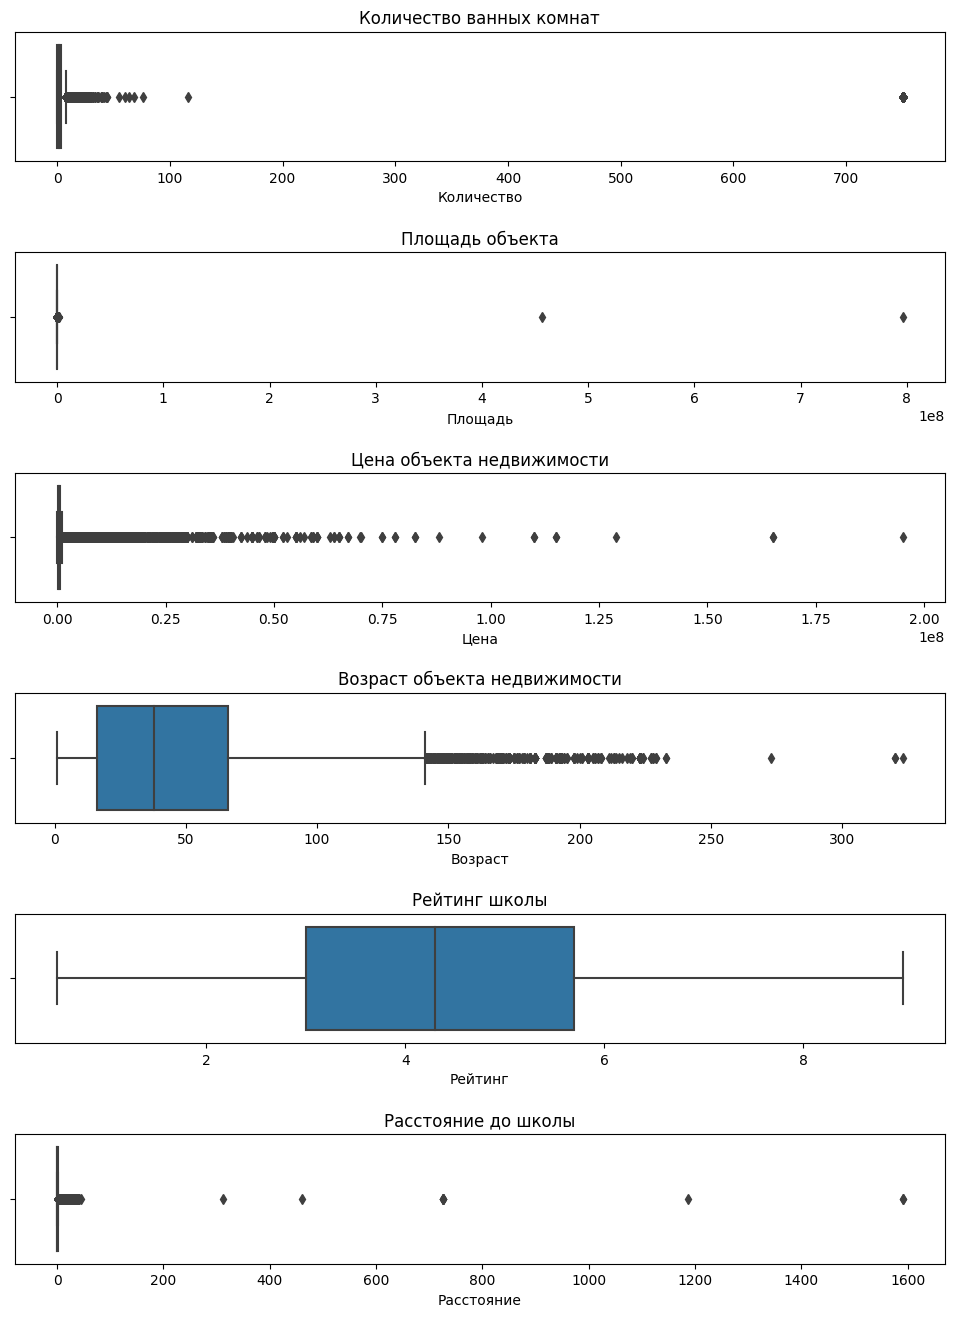

In [58]:
# Коробчатые диаграммы для выявления выбросов.
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(12, 16))
plt.subplots_adjust(hspace = 0.7)

histplot = sns.boxplot(data=df, x='baths',  ax=axes[0]);
histplot.set_title('Количество ванных комнат');
histplot.set_xlabel('Количество');

histplot = sns.boxplot(data=df, x='sqft',  ax=axes[1]);
histplot.set_title('Площадь объекта');
histplot.set_xlabel('Площадь');

histplot = sns.boxplot(data=df, x='target',  ax=axes[2]);
histplot.set_title('Цена объекта недвижимости');
histplot.set_xlabel('Цена');

histplot = sns.boxplot(data=df, x='age_building',  ax=axes[3]);
histplot.set_title('Возраст объекта недвижимости');
histplot.set_xlabel('Возраст');

histplot = sns.boxplot(data=df, x='school_rating',  ax=axes[4]);
histplot.set_title('Рейтинг школы');
histplot.set_xlabel('Рейтинг');

histplot = sns.boxplot(data=df, x='school_distance',  ax=axes[5]);
histplot.set_title('Расстояние до школы');
histplot.set_xlabel('Расстояние');

По полученным диаграммам явно видны выбросы в признаках по ванным комнатам (baths), площади (sqft) и расстоянию до школы (school_distance). Удалим выбросы в указанных признаках. Остальные стоит немного подкорректировать.

In [59]:
# Подсчитываем и удаляем выбросы.

baths_count_del = df[df['baths'] > 100].shape[0]
df = df[df['baths'] <= 100]

sqft_count_del = df[df['sqft'] > 250000].shape[0]
df = df[df['sqft'] <= 250000]

age_count_del = df[df['age_building'] > 250].shape[0]
df = df[df['age_building'] <= 250]

school_count_del = df[df['school_distance'] > 30].shape[0]
df = df[df['school_distance'] <= 30]

target_count_del = df[df['target'] > 1e+08].shape[0]
df = df[df['target'] <= 1e+08]

print('Количество удаленных выбросов по ваннам: ', baths_count_del)
print('Количество удаленных выбросов по площадям объектов: ', sqft_count_del)
print('Количество удаленных выбросов по возрастам объектов: ', age_count_del)
print('Количество удаленных выбросов по расстоянию до школы: ', school_count_del)
print('Количество удаленных выбросов по стоимости объекта: ', target_count_del)

Количество удаленных выбросов по ваннам:  231
Количество удаленных выбросов по площадям объектов:  232
Количество удаленных выбросов по возрастам объектов:  4
Количество удаленных выбросов по расстоянию до школы:  234
Количество удаленных выбросов по стоимости объекта:  8


Повторно визуализируем полученные данные после удаленных выбросов при помощи коробчатых диаграмм и гистограмм распределения.

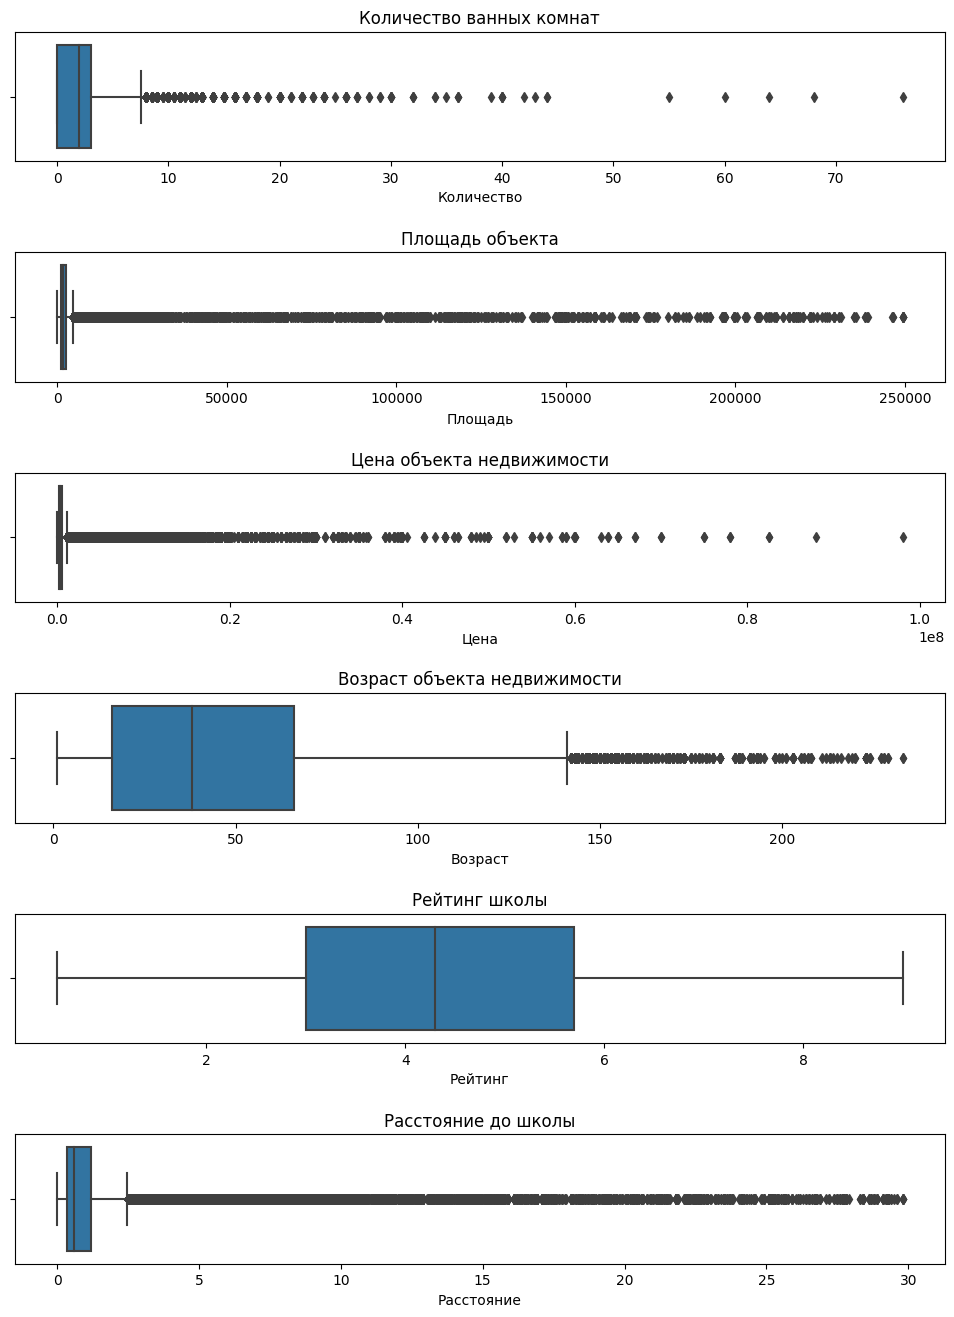

In [60]:
# Коробчатые диаграммы полсе удаления выбросов.
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(12, 16))
plt.subplots_adjust(hspace = 0.7)

histplot = sns.boxplot(data=df, x='baths',  ax=axes[0]);
histplot.set_title('Количество ванных комнат');
histplot.set_xlabel('Количество');

histplot = sns.boxplot(data=df, x='sqft',  ax=axes[1]);
histplot.set_title('Площадь объекта');
histplot.set_xlabel('Площадь');

histplot = sns.boxplot(data=df, x='target',  ax=axes[2]);
histplot.set_title('Цена объекта недвижимости');
histplot.set_xlabel('Цена');

histplot = sns.boxplot(data=df, x='age_building',  ax=axes[3]);
histplot.set_title('Возраст объекта недвижимости');
histplot.set_xlabel('Возраст');

histplot = sns.boxplot(data=df, x='school_rating',  ax=axes[4]);
histplot.set_title('Рейтинг школы');
histplot.set_xlabel('Рейтинг');

histplot = sns.boxplot(data=df, x='school_distance',  ax=axes[5]);
histplot.set_title('Расстояние до школы');
histplot.set_xlabel('Расстояние');

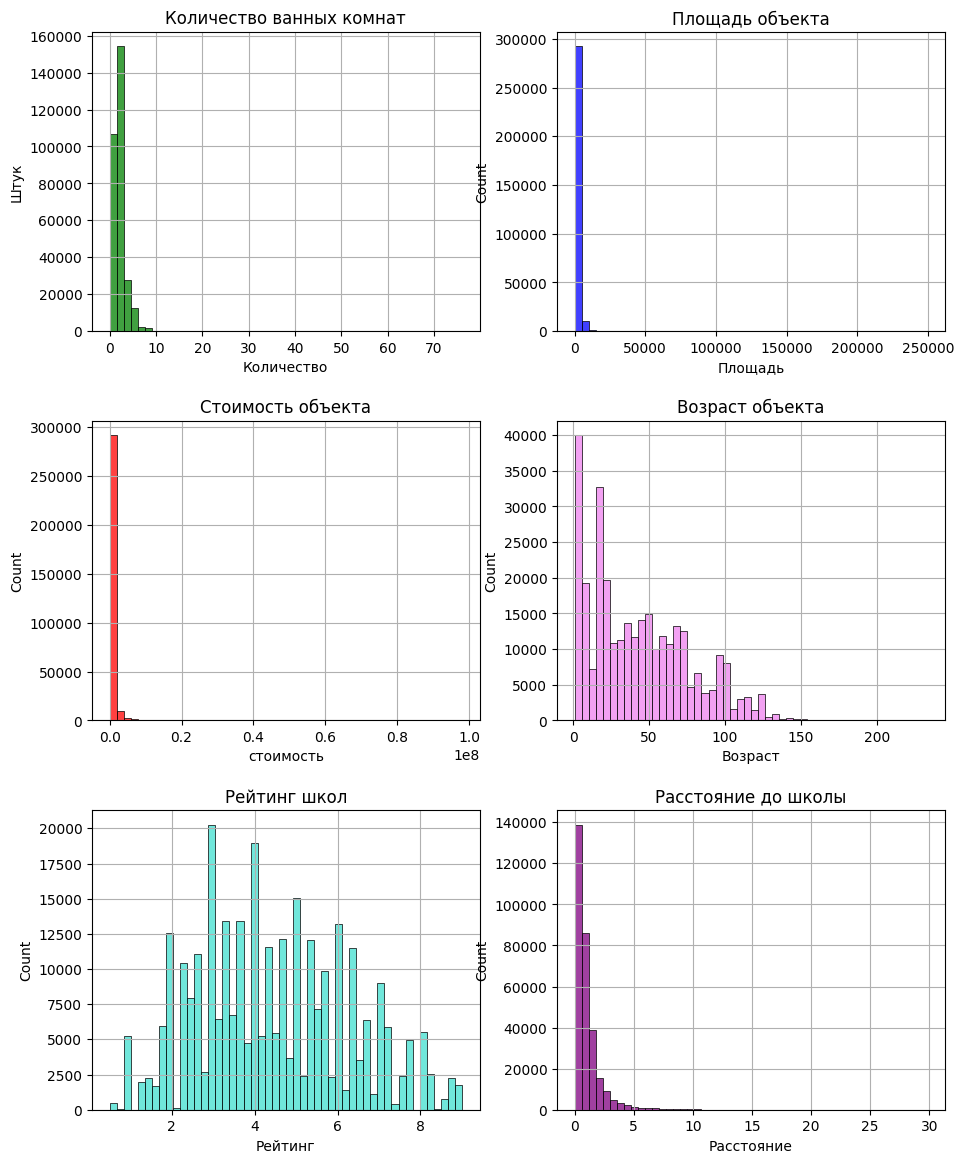

In [61]:
# Гистограммы распределения.
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(11, 14))
plt.subplots_adjust(hspace = 0.3)

# Распределение баланса.
histplot_balance = sns.histplot(
    ax=axes[0,0],
    data=df,
    x='baths',
    bins=50,
    color='green',)
histplot_balance.set_title('Количество ванных комнат', fontsize=12);
histplot_balance.set_xlabel('Количество');
histplot_balance.set_ylabel('Штук');
histplot_balance.grid()

# Распределение возраста.
histplot_age = sns.histplot(
    ax=axes[0,1],
    data=df,
    x='sqft',
    bins=50,
    color='blue',)
histplot_age.set_title('Площадь объекта', fontsize=12);
histplot_age.set_xlabel('Площадь');
histplot_age.grid()

# Распределение баланса.
histplot_balance = sns.histplot(
    ax=axes[1,0],
    data=df,
    x='target',
    bins=50,
    color='red',)
histplot_balance.set_title('Стоимость объекта', fontsize=12);
histplot_balance.set_xlabel('стоимость');
histplot_balance.grid()

# Распределение возраста.
histplot_age = sns.histplot(
    ax=axes[1,1],
    data=df,
    x='age_building',
    bins=50,
    color='violet',)
histplot_age.set_title('Возраст объекта', fontsize=12);
histplot_age.set_xlabel('Возраст');
histplot_age.grid()

# Распределение баланса.
histplot_balance = sns.histplot(
    ax=axes[2,0],
    data=df,
    x='school_rating',
    bins=50,
    color='turquoise',)
histplot_balance.set_title('Рейтинг школ', fontsize=12);
histplot_balance.set_xlabel('Рейтинг');
histplot_balance.grid()

# Распределение возраста.
histplot_age = sns.histplot(
    ax=axes[2,1],
    data=df,
    x='school_distance',
    bins=50,
    color='purple',)
histplot_age.set_title('Расстояние до школы', fontsize=12);
histplot_age.set_xlabel('Расстояние');
histplot_age.grid()

Посмотрим внимательнее на распределение таргета в изначальном и логарифмическом масштабе.

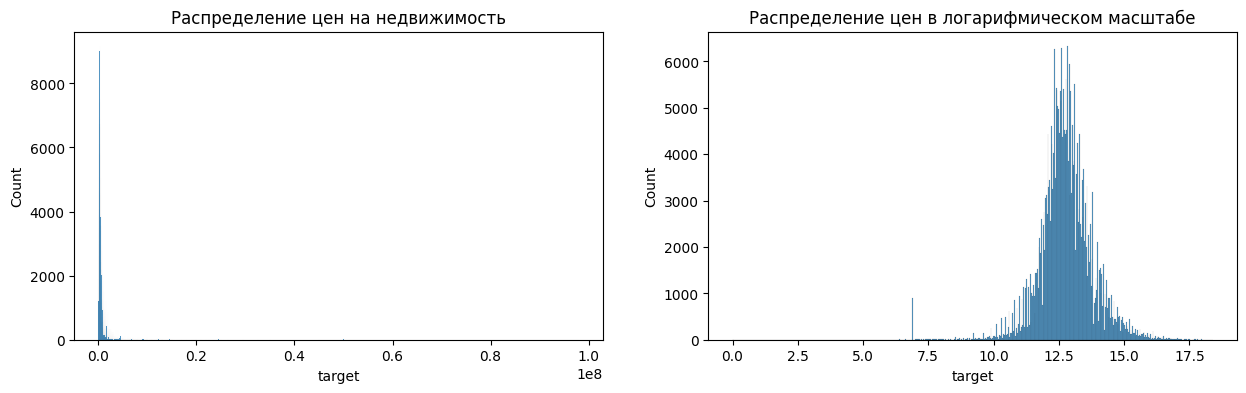

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# Гистограмма распределения в изначальном масштабе.
histplot1 = sns.histplot(data=df, x='target', ax=axes[0]);
histplot1.set_title('Распределение цен на недвижимость');

# Гистограмма распределения в логарифмическом масштабе.
log_target = np.log(df['target'])
histplot2 = sns.histplot(data=log_target, ax=axes[1]);
histplot2.set_title('Распределение цен в логарифмическом масштабе');

Целевой признак в изначальном масштабе распределен ненормально. В логарифмическом масштабе он распределен нормально. Данная информация будет полезна, когда будет производиться обучение моделей.  

Далее посмотрим на матрицу корреляции.

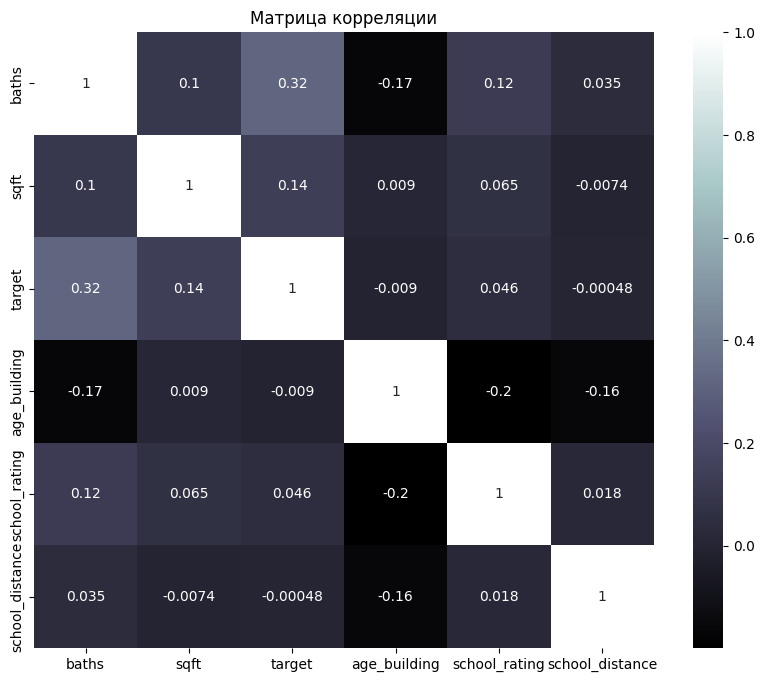

In [63]:
# Матрица корреляции для числовых признаков.
matrix_corr = df[['baths', 'sqft', 'target', 'age_building', 'school_rating', 'school_distance']]

fig, ax = plt.subplots(figsize=(10, 8))
heatmap = sns.heatmap(matrix_corr.corr(), cmap='bone', annot=True)
heatmap.set_title('Матрица корреляции');

По матрице видно, что мультиколлениарность отсутствует. Поэтому все признаки оставляем для дальнейшей работы.  

Посмотрим на количество и среднюю стоимость объектов в зависимости от города. Для этого сгруппируем города по количеству и средней стоимости объектов. Выведем 20 первых городов по количеству продаваемых объектов.

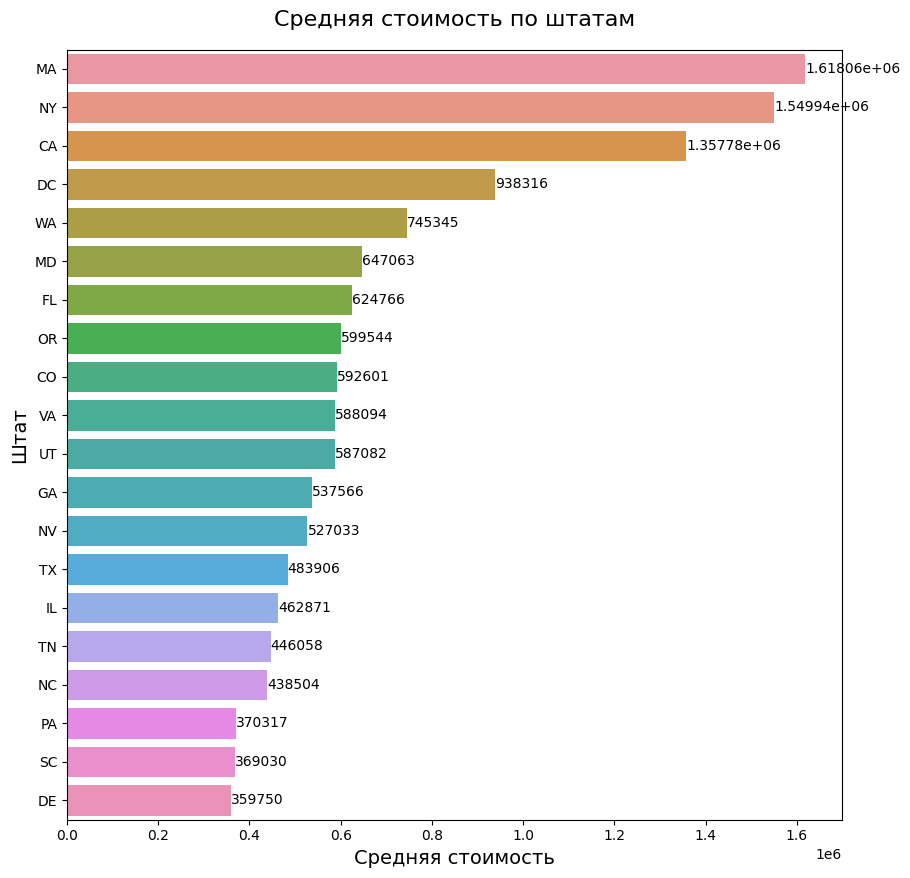

In [64]:
# Группировка средней стоимости по штатам.
average_price = df.groupby(['state'])['target'].mean()

# Преобразование и сортировка.
average_price = pd.DataFrame(average_price)
average_price.reset_index(inplace=True)
average_price.sort_values(by='target', ascending=False, inplace=True)

average_price = average_price.iloc[:20]

# Столбчатая диаграмма.
fig = plt.figure(figsize=(10, 10))
barplot = sns.barplot(
    average_price, 
    x = list(average_price['target']), 
    y = list(average_price['state']),
)
barplot.bar_label(barplot.containers[0])
barplot.set_title('Средняя стоимость по штатам', fontsize=16, x=0.5, y=1.02);
barplot.set_ylabel('Штат', fontsize=14);
barplot.set_xlabel('Средняя стоимость', fontsize=14);

Как можно видеть на диаграмме, самые высокие цены на недвижимость имеют штаты Массачусетс, Нью-Йорк и Калифорния. Самые низкие цены имеют штаты Пенсильвания, Южная Каролина и Делавэр.  

Далее можно выдвинуть гипотезу о прямой зависимости стоимости объектов от их площади. Проверим данную гипотезу диаграммой рассеяния.

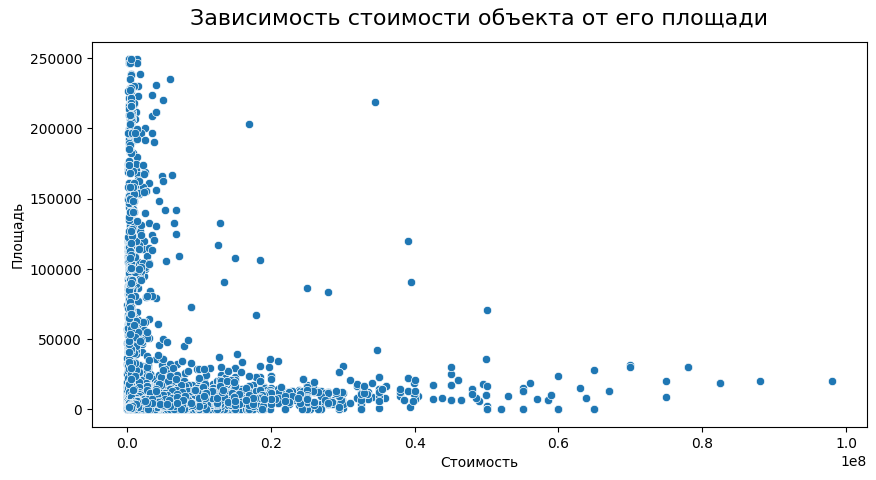

In [65]:
# Диаграмма зависимости стоимости от площади.
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(
    df,
    x=list(df['target']),
    y=list(df['sqft']),
    ax=ax)
ax.set_title('Зависимость стоимости объекта от его площади', fontsize=16, x=0.5, y=1.02);
ax.set_xlabel('Стоимость')
ax.set_ylabel('Площадь');

Гипотеза о прямой зависимости стоимости от площади не подтвердилась. Это можно объяснить тем, что в разных штатах стоимость объектов сильно различается.  

Далее посмотрим на зависимость стоимости жилья от его возраста.

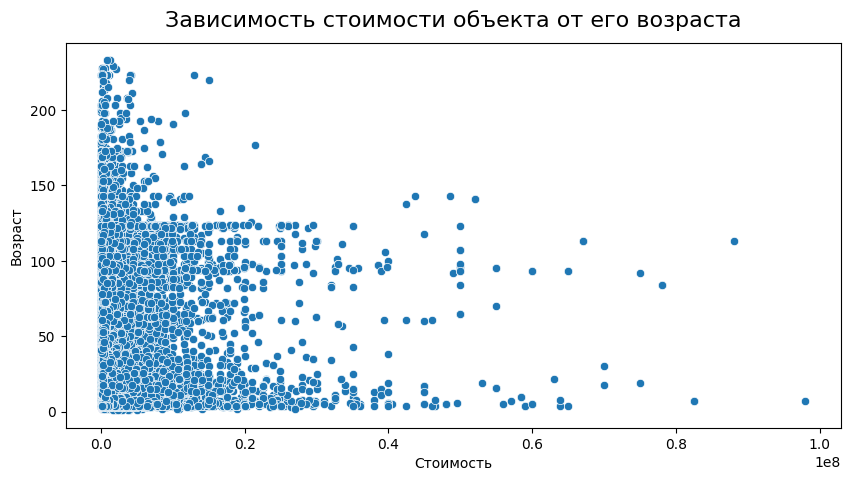

In [66]:
# Диаграмма зависимости стоимости объекта от возраста.
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(
    df,
    x=list(df['target']),
    y=list(df['age_building']),
    ax=ax)
ax.set_title('Зависимость стоимости объекта от его возраста', fontsize=16, x=0.5, y=1.02);
ax.set_xlabel('Стоимость')
ax.set_ylabel('Возраст');

Как можно видеть, стоимость объектов не зависит от возраста.

Посмотрим на 30 городов, в которых наибольший и наименьший средний рейтинг школ.

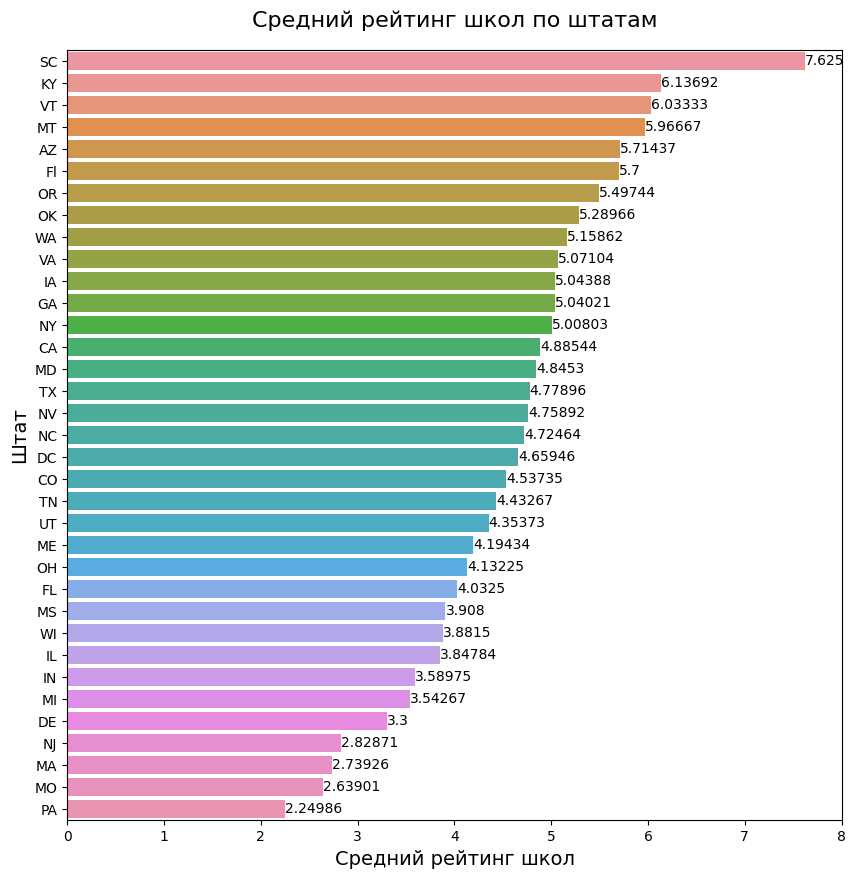

In [67]:
# Группировка штатов по среднему рейтингу школ.
average_school_rating = df.groupby(['state'])['school_rating'].mean()

# Преобразование и сортировка.
average_school_rating = pd.DataFrame(average_school_rating)
average_school_rating.reset_index(inplace=True)
average_school_rating.sort_values(by='school_rating', ascending=False, inplace=True)

# Столбчатая диаграмма.
fig = plt.figure(figsize=(10, 10))
barplot = sns.barplot(
    average_school_rating, 
    x = list(average_school_rating['school_rating']), 
    y = list(average_school_rating['state']),
)
barplot.bar_label(barplot.containers[0])
barplot.set_title('Средний рейтинг школ по штатам', fontsize=16, x=0.5, y=1.02);
barplot.set_ylabel('Штат', fontsize=14);
barplot.set_xlabel('Средний рейтинг школ', fontsize=14);

Интересно заметить, что самый высокий рейтинг школ имеет штат Южная Каролина (SC), в то время как этот штат находится на предпоследнем месте по стоимости объектов.

Далее посмотрим на количество значений в категориальных признаках для кодирования.

In [68]:
# Выведем количество значений в категориальных признаках.
# Список категориальных признаков.
categorical_factors = ['status', 'city', 'zipcode', 'state']

# Подсчет уникальных значений в категориальных признаках.
for col in categorical_factors:
   unique_values = df[col].nunique()
   print('Количество уникальных значений в категориальном признаке', col, ':', unique_values)

Количество уникальных значений в категориальном признаке status : 11
Количество уникальных значений в категориальном признаке city : 1699
Количество уникальных значений в категориальном признаке zipcode : 4041
Количество уникальных значений в категориальном признаке state : 35


Признаки 'status' и 'state' имеют 11 и 35 уникальных значений соответственно. Это не много, поэтому закодируем их однократным кодированием get_dummies. Остальные два категориальных признака имеют очень большое количество уникальных значений. Для них подойдет двоичное кодирование BinaryEncoder.

In [69]:
# Однократное кодирование признаков 'status' и 'state'
df = pd.get_dummies(df, columns=['status', 'state'])

# Двоичное кодирование признака 'city'.
bin_encoder1 = ce.BinaryEncoder(cols=['city'])
type_bin = bin_encoder1.fit_transform(df['city'])
df = pd.concat([df, type_bin], axis=1)

# Двоичное кодирование признака 'zipcode'.
bin_encoder2 = ce.BinaryEncoder(cols=['zipcode'])
type_bin = bin_encoder2.fit_transform(df['zipcode'])
df = pd.concat([df, type_bin], axis=1)

# Удаление закодированных признаков.
df = df.drop(['city', 'zipcode'], axis=1)

# Выведем полученный датасет после всех обработок, на котором будет производиться обучение модели.
display(df)
display(df.info())

,baths,fireplace,sqft,target,pool,Heating,Cooling,Parking,age_building,school_rating,...,zipcode_2,zipcode_3,zipcode_4,zipcode_5,zipcode_6,zipcode_7,zipcode_8,zipcode_9,zipcode_10,zipcode_11
0,3.5,True,2900,418000,True,True,True,True,4,5.2,...,0,0,0,0,0,0,0,0,0,1
1,3.0,True,1947,310000,True,True,True,True,4,4.0,...,0,0,0,0,0,0,0,0,1,0
2,2.0,True,3000,2895000,True,True,True,True,62,6.7,...,0,0,0,0,0,0,0,0,1,1
3,8.0,True,6457,2395000,True,True,True,True,17,5.6,...,0,0,0,0,0,0,0,1,0,0
6,0.0,True,1507,181500,True,True,True,True,17,2.3,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377179,3.0,True,1417,799000,True,True,True,True,13,3.0,...,1,1,0,1,1,0,0,0,1,0
377180,6.0,True,4017,1249000,True,True,True,True,33,2.0,...,1,0,0,1,0,1,1,0,1,0
377181,3.0,True,2000,674999,True,True,True,True,99,4.3,...,0,0,1,1,1,1,0,0,0,0
377182,3.0,True,1152,528000,True,True,True,True,73,4.5,...,0,1,0,1,1,0,1,0,0,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 305970 entries, 0 to 377184
Data columns (total 80 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   baths                  305970 non-null  float64
 1   fireplace              305970 non-null  bool   
 2   sqft                   305970 non-null  int32  
 3   target                 305970 non-null  int32  
 4   pool                   305970 non-null  bool   
 5   Heating                305970 non-null  bool   
 6   Cooling                305970 non-null  bool   
 7   Parking                305970 non-null  bool   
 8   age_building           305970 non-null  int64  
 9   school_rating          305970 non-null  float64
 10  school_distance        305970 non-null  float64
 11  status_Active          305970 non-null  uint8  
 12  status_Auction         305970 non-null  uint8  
 13  status_Back on market  305970 non-null  uint8  
 14  status_Contingent      305970 non-nu

None

# Проектирование моделей регрессии

Для начала построим модель линейной регрессии. Предварительно перед этим логарифмируем целевой признак, произведем разделение данных на тренировочную и тестовую выборки и произведем нормализацию факторов.

In [70]:
# Логорифмирование целевого признака 'target' с ценой объектов.
df['target_log'] = np.log(df['target'])

# Определим целевую переменную и предикторы.
X = df.drop(['target', 'target_log'], axis=1)
y = df['target_log']

# Разделение выборки на обучающую и тестовую.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

# Размер обучающей выборки.
print(f'Размер обучающей выборки: {X_train.shape[0]}')

# Размер тестовой выборки.
print(f'Размер тестовой выборки: {X_test.shape[0]}')

Размер обучающей выборки: 214179
Размер тестовой выборки: 91791


In [71]:
# Нормализатор MinMaxScaler.
mm_scaler = preprocessing.MinMaxScaler()

# Нормализация данных.
X_train_mm = mm_scaler.fit_transform(X_train)
X_test_mm = mm_scaler.transform(X_test)

# Обратно преобразуем в DataFrame полученные массивы после нормализации.
columns = X_train.columns
X_train_norm = pd.DataFrame(X_train_mm, columns = columns)
X_test_norm = pd.DataFrame(X_test_mm, columns = columns)

### Модель линейной регрессии **LinearRegression**

В качестве метрики возьмём RMSLE (Root Mean Squared Log Error), по которой будем измерять качество наших дальнейших моделей.

In [72]:
# Инициализируем LinearRegression.
lin_reg_model = linear_model.LinearRegression()

# Обучаем модель линейной регрессии.
lin_reg_model.fit(X_train_norm, y_train)

# Делаем предсказания.
y_train_pred = lin_reg_model.predict(X_train_norm)
y_test_pred = lin_reg_model.predict(X_test_norm)

# Посчитаем метрики RMSLE, полученные в результате работы модели линейной регрессии.
train_rmsle = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
test_rmsle = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

# Выводим полученные метрики RMSLE.
print('Значение RMSLE линейной регрессии на тренировочной выборке: ', round(train_rmsle,2))
print('Значение RMSLE линейной регрессии на тестовой выборке: ', round(test_rmsle,2))

Значение RMSLE линейной регрессии на тренировочной выборке:  0.78
Значение RMSLE линейной регрессии на тестовой выборке:  0.77


Полученные метрики далеки от идеальных. Поэтому построим полиномиальную регрессию второй степени.

In [73]:
# Создаём генератор полиномиальных признаков.
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train)

# Генерируем полиномиальные признаки для тренировочной и тестовой выборок.
X_train_poly = poly.transform(X_train_norm)
X_test_poly = poly.transform(X_test_norm)

# Инициализируем и обучаем полиномиальную регрессию.
lr_poly = linear_model.LinearRegression()
lr_poly.fit(X_train_poly, y_train)

# Предсказания полиномиальной регрессии.
y_train_pred = lr_poly.predict(X_train_poly)
y_test_pred = lr_poly.predict(X_test_poly)

# Посчитаем метрики RMSLE, полученные в результате работы модели полиномиальной регрессии.
train_rmsle = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
test_rmsle = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

# Выводим полученные метрики RMSLE.
print('Значение RMSLE полиномиальной регрессии на тренировочной выборке: ', round(train_rmsle,2))
print('Значение RMSLE полиномиальной регрессии на тестовой выборке: ', round(test_rmsle,2))

Значение RMSLE полиномиальной регрессии на тренировочной выборке:  0.58
Значение RMSLE полиномиальной регрессии на тестовой выборке:  1046365563.32


Метрика RMSLE значительно улучшилась на тренировочной выборке, но на тестовой выборке метрика получилась неадекватная - произошло переобучение модели. Поэтому построим модель полиномиальной регрессии с L2-регуляризацией для исключения переобучения.

In [74]:
# Создаём объект класса линейной регрессии с L2-регуляризацией.
ridge_lr = linear_model.Ridge(alpha=0.2)

# Обучаем модель.
ridge_lr.fit(X_train_poly, y_train)

# Делаем предсказания для тренировочной и тестовой выборок.
y_train_pred = ridge_lr.predict(X_train_poly)
y_test_pred = ridge_lr.predict(X_test_poly)

# Посчитаем метрики RMSLE, полученные в результате работы модели полиномиальной регрессии с L2-регуляризацией.
train_rmsle = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
test_rmsle = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

# Выводим полученные метрики RMSLE.
print('Значение RMSLE регрессии с L2-регуляризацией на тренировочной выборке: ', round(train_rmsle,2))
print('Значение RMSLE регрессии с L2-регуляризацией на тестовой выборке: ', round(test_rmsle,2))

Значение RMSLE регрессии с L2-регуляризацией на тренировочной выборке:  0.58
Значение RMSLE регрессии с L2-регуляризацией на тестовой выборке:  0.58


После обучения полиномиальной регрессии с L2-регуляризацией метрика RMSLE значительно улучшились по сравнению с изначальной линейной регрессией. Так как метрики равны на тренировочной и тестовой выборках, то модель не переобучена.

Чтобы попытаться улучшить получившееся метрики RMSLE, далее создадим модель дерева решений.

### Модель дерева решений **DecisionTreeRegressor**

In [75]:
# Создаем и обучаем модель дерева решений.
dt_reg = tree.DecisionTreeRegressor(random_state=42)
dt_reg.fit(X_train_norm, y_train)

# Предсказания модели.
y_train_pred = dt_reg.predict(X_train_norm)
y_test_pred = dt_reg.predict(X_test_norm)

# Посчитаем метрики RMSLE, полученные в результате работы модели дерева решений.
train_rmsle = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
test_rmsle = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

# Выводим полученные метрики RMSLE.
print('Значение RMSLE дерева решений на тренировочной выборке: ', round(train_rmsle,2))
print('Значение RMSLE дерева решений на тестовой выборке: ', round(test_rmsle,2))

Значение RMSLE дерева решений на тренировочной выборке:  0.02
Значение RMSLE дерева решений на тестовой выборке:  0.57


По полученным метрикам можно увидеть, что модель идеально подстроилась под обучающую выборку и метрика RMSLE на тренировочных данных почти равна нулю. Это говорит о том, что модель максимально переобучена. Это произошло потому что не было ограничений на глубину дерева. Теперь стоит перебрать значения глубины дерева, чтобы исключить переобучение модели.

Оптимальная глубина дерева решений: 24
RMSLE на тренировочной выборке: 0.28
RMSLE на тестовой выборке: 0.55


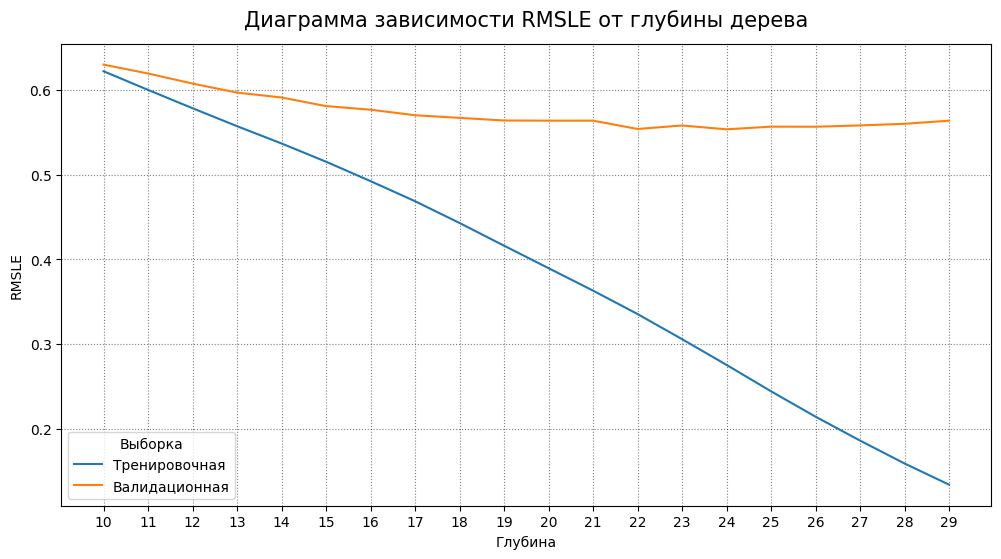

In [76]:
# Создаём список значений глубины от 10 до 30.
max_depths = range(10, 30)

# Создаем пустые списки, в которые будем добавлять результаты RMSLE.
train_scores = []
valid_scores = []

for depth in max_depths:
    # Создаем и обучаем модель дерева решений.
    dt_reg = tree.DecisionTreeRegressor(max_depth=depth, random_state=42)
    dt_reg.fit(X_train_norm, y_train)
    # Делаем предсказание для тренировочной и валидационной выборок.
    y_train_pred = dt_reg.predict(X_train_norm)
    y_test_pred = dt_reg.predict(X_test_norm)
    # Расчитываем метрики RMSLE и добавляем их в списки.
    train_scores.append(np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)))
    valid_scores.append(np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

# Диаграмма зависимости RMSLE от глубины дерева.
fig, ax = plt.subplots(figsize = (12, 6))
# Линейные графики тренировочной и валидационной выборок.
ax.plot(max_depths, train_scores)
ax.plot(max_depths, valid_scores)
ax.grid(alpha=0.5, color='black', linestyle=':')
ax.legend(title='Выборка', loc='lower left', labels=['Тренировочная', 'Валидационная']);
ax.set_title('Диаграмма зависимости RMSLE от глубины дерева', fontsize=15, x=0.5, y=1.02);
ax.set_xlabel('Глубина')
ax.set_ylabel('RMSLE')
ax.set_xticks(max_depths)

# Находим индекс наименьшего значения RMSLE на валидационных данных.
rmsle_min = valid_scores.index(min(valid_scores))
# Извлекаем по индексу из max_depths наименьшее значение RMSLE.
print('Оптимальная глубина дерева решений:', max_depths[rmsle_min])
# Извлекаем в тренировочных и валидационных списках ранее найденные метрики RMSLE по найденному индексу.
print('RMSLE на тренировочной выборке:', round(train_scores[rmsle_min], 2))
print('RMSLE на тестовой выборке:', round(valid_scores[rmsle_min], 2))

В результате перебора глубины дерева было найдено оптимальное значение равное 24 при котором метрика RMSLE равна 0.55 на тестовой выборке. Значение метрики RMSLE в результате работы модели дерева решений немного улучшилось по сравнению с предыдущими моделями.

Далее применим ансамблевые методы построения моделей регрессии.

### Ансамблевые методы решения задач линейной регрессии.

Построим модель случайного леса.

In [77]:
# Создаём объект класса RandomForestRegressor.
rf_reg = ensemble.RandomForestRegressor(
    n_estimators = 500,
    max_depth = 24,
    criterion = 'squared_error',
    min_samples_split = 20,
    random_state = 42,
    n_jobs = -1
)
# Обучение модели.
rf_reg.fit(X_train_norm, y_train)

# Предсказания модели.
y_train_pred = rf_reg.predict(X_train_norm)
y_test_pred = rf_reg.predict(X_test_norm)

# Метрики RMSLE.
print('RMSLE на тренировочной выборке:', round(np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)), 2))
print('RMSLE на валидационной выборке:', round(np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)), 2))

RMSLE на тренировочной выборке: 0.35
RMSLE на валидационной выборке: 0.44


В результате работы модели случайного леса удалось значительно улучшить метрику RMSLE на тестовой выборке, которая стала равна 0.44.

Теперь построим модель градиентного бустинга над деревьями решений (GradientBoostingRegressor). Подбирать гиперпараметры будем при помощи GridSearchCV. После этого для экономии времени для дальнейшей работы закомментируем GridSearchCV и введем полученные параметры прямо в модель GradientBoostingRegressor минуя сетку. 

In [78]:
# Подбор оптимальных параметров с помощью GridSearchCV.

# # Список гиперпараметров для класса GradientBoostingRegressor для оптимизации:
# param_grid = {
#     'min_samples_split': [15, 20, 25, 30],
#     'max_depth': [6, 7, 8, 9, 10],
# }
# # В класс GridSearchCV передаем модель класса GradientBoostingRegressor и сетку искомых гиперпараметров 'param_grid'.
# grid_search = GridSearchCV(
#     ensemble.GradientBoostingRegressor(
#         random_state=42,
#         learning_rate = 0.5,
#         n_estimators = 200,
#         ),
#     param_grid=param_grid,  
#     n_jobs = -1
# )
# # Обучаем модель по алгоритму.
# grid_search.fit(X_train_norm, y_train)

# # Выводим значение метрики RMSLE для тестовой выборки и значения наилучших гиперпараметров.
# print('RMSLE на тестовой выборке: ', round(np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)), 2))
# print('Наилучшие значения гиперпараметров: ', grid_search.best_params_)

В результате поиска параметров по сетке для наилучшего значения метрики RMSLE на тестовой выборке были найдены следующие параметры:  
* 'max_depth': 8  
* 'min_samples_split': 20  
* 'n_estimators': 200  
* 'learning_rate': 0.5  

In [79]:
# Создаём объект класса GradientBoostingRegressor и прописываем параметры, найденные при помощи GridSearchCV.
gb_reg = ensemble.GradientBoostingRegressor(
    learning_rate = 0.5,
    n_estimators = 200,
    max_depth = 8,
    min_samples_split = 20,
    random_state = 42
)
# Обучение модели.
gb_reg.fit(X_train_norm, y_train)

# Предсказания модели
y_train_pred = gb_reg.predict(X_train_norm)
y_test_pred = gb_reg.predict(X_test_norm)

# Метрики RMSLE.
print('RMSLE на тренировочной выборке:', round(np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)), 2))
print('RMSLE на валидационной выборке:', round(np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)), 2))

RMSLE на тренировочной выборке: 0.28
RMSLE на валидационной выборке: 0.41


Построив несколько моделей регрессии, наилучшая метрика RMSLE, равная 0.41, была достигнута при ансамблевом методе GradientBoostingRegressor. Теперь посмотрим на 20 самых важных факторов для полученной модели gb_reg.

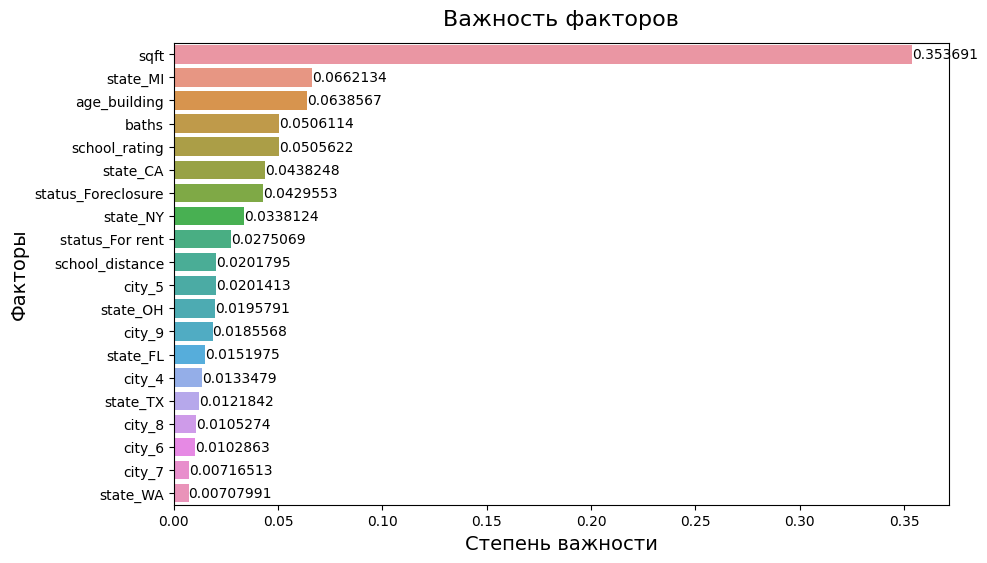

In [80]:
# Извлекаем важность признаков с названиями.
importances = gb_reg.feature_importances_

# Преобразуем извлеченные признаки в датасет для сортировки и подачи его для визуализации.
feature_list = list(X_train_norm.columns)
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
feature_results = feature_results.sort_values('importance', ascending=False).reset_index(drop=True)

# Визуализируем 20 самых важных факторов.
feature_results = feature_results[:20]
fig = plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    feature_results, 
    x = list(feature_results['importance']), 
    y = list(feature_results['feature']),
)
barplot.bar_label(barplot.containers[0])
barplot.set_title('Важность факторов', fontsize=16, x=0.5, y=1.02);
barplot.set_ylabel('Факторы', fontsize=14);
barplot.set_xlabel('Степень важности', fontsize=14);

Самыми важными факторами являются: площадь, возраст объекта, площадь ванн, рейтинг школ и расстояния до них. Среди важных факторов есть штаты MI, CA, NY и др. Они оказывают сильное влияние на таргет, потому что в этих штатах самые высокие цены на недвижимость. В этом можно убедиться, посмотрев на ранее созданную визуализацию зависимости цен от штата.

Далее, когда получена обученная модель, необходимо ее сериализовать, превратив объект Python в поток байтов для дальнейшего развертывания на сервере. Для этого нужно импортировать модуль pickle и воспользоваться функцией dump(), в которую нужно передать объект Python.

In [81]:
# Производим сериализацию обученной модели.
with open('regression_model.pkl', 'wb') as output:
    pickle.dump(gb_reg, output)

Далее десериализуем модель из файла и проверим ее работоспособность, сравнив результаты предсказания для тестовой выборки до сериализации и после.

In [82]:
# Десериализуем модель из файла.
with open('regression_model.pkl', 'rb') as pkl_file:
    regressor_from_file = pickle.load(pkl_file)

# Проверяем сходимость результатов работы десериализованной модели.
if all(gb_reg.predict(X_test_norm) == regressor_from_file.predict(X_test_norm)):
    print('Модель предсказания цен на недвижимость работоспособна. \nСериализация и десериалезация модели регрессии прошли успешно. \nМодель верно делает предсказания стоимости объектов и ее можно внедрять в продакшен.')
else: print('Модель неработоспособна.')

Модель предсказания цен на недвижимость работоспособна. 
Сериализация и десериалезация модели регрессии прошли успешно. 
Модель верно делает предсказания стоимости объектов и ее можно внедрять в продакшен.


# Выводы

Целью данной работы было создать модель, которая позволила бы агентству недвижимости повысить конкурентоспособность по скорости и качеству совершения сделок.
В ходе выполнения данного проекта были произведены следующие шаги по созданию модели:  
* была произведена очистка данных, удалены дублирующиеся категории, ошибки ввода, жаргонные сокращения, найдены синонимы в данных, обработаны пропуски и удалены выбросы;  
* произведен разведывательный анализ данных и найдены закономерности в них, были выделены наиболее значимые факторы, влияющие на стоимость недвижимости;  
* построены несколько моделей для прогнозирования стоимости недвижимости, произведена оценка их метрик качества и выбран оптимальный вариант.  

В исходных данных было слишком много пропусков, ошибок ввода и жаргонных сокращений. Эти ошибки и сокращения были исправлены и категоризованны. Числовые характеристики объектов были нечитаемы для обучения моделей и поэтому они были обработаны для приведения к единому формату. Из исходных данных была полученна ценная информация для проектирования новых признаков.  

После этого были выявлены первые закономерности в данных и их скоррелированность между собой. Построены графики и по ним был произведен анализ факторов влияющих на цену недвижимости, таких как площадь объектов, штат, в которых они расположены, рейтинг и удаленность школ от этих объектов.  

На полученных в ходе обработки и анализа данных построены несколько моделей регрессии, таких как линейная и полиномиальная регрессии, деревья, случайный лес и ансамблевые методы построения моделей, предсказывающих цены на недвижимость. По метрикам качества был выбран оптимальный вариант модели, полученной при ансамблевом методе GradientBoostingRegressor. После этого данная модель была сериализованна для внедрения в продакшен.